# Sea ice seasonal cycle

In [3]:
import sys
import glob
import numpy as np
import pandas as pd
import xarray as xr
import cmocean
import cartopy
import calendar
import matplotlib
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [4]:
sys.path.append("..")
%matplotlib inline
matplotlib.rc_file('../rc_file')
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}
%load_ext autoreload
%autoreload 2
%aimport - numpy - matplotlib.pyplot

In [63]:
from paths import path_results, path_samoc,path_data
from timeseries import IterateOutputCESM
from tqdm.autonotebook import tqdm

In [39]:
# %%time
# # stacking files into one xr Dataset object
# # lpd: 1min 5s
# for j, run in enumerate(['ctrl', 'lpd','rcp','lr1']):
#     if j<=1: continue
#     (ys, ye) = [(200,230),(500,530),(2090,2100),(2090,2100)][j]
#     domain = ['ocn','ocn_low','ocn','ocn_low'][j]
#     nequator = [1000,190,1000,190][j]
#     fn_a  = f'{path_samoc}/CICE/CICE_Arctic_{run}.nc'
#     fn_aa = f'{path_samoc}/CICE/CICE_Antarctic_{run}.nc'
#     a, aa = [], []
#     print(run)
#     for i, (y,m,s) in tqdm(enumerate(IterateOutputCESM('ice', run, 'monthly'))):
#         if y<ys or y>ye:  continue
#         da = xr.open_dataset(s, decode_times=False)
#         a .append((da.aice[0,:,:]*da.tarea.where(da.nj>nequator)).sum())
#         aa.append((da.aice[0,:,:]*da.tarea.where(da.nj<nequator)).sum())
#     xr.concat(a , dim='time').to_netcdf(fn_a )
#     xr.concat(aa, dim='time').to_netcdf(fn_aa)
    
# # 8 min

rcp


The file "/projects/0/prace_imau/prace_2013081679/cesm1_0_4/rcp8.5_co2_f05_t12/OUTPUT/ice/hist/monthlies/rcp8.5_co2_f05_t12.cice.h.2101-02.nc" does not exist

lr1


The file "/projects/0/acc/cesm/cesm1_1_2/rcp8.5_co2_f09_g16/OUTPUT/ice/hist/rcp8.5_co2_f09_g16.cice.h.2101-01.nc" does not exist

CPU times: user 2min 20s, sys: 2min 24s, total: 4min 45s
Wall time: 6min 37s


0 1990
0 2000
0 2010
0 2020


/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/xarray/core/dataarray.py:2979: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs
/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/xarray/core/dataarray.py:2979: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs
/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/xarray/core/dataarray.py:2979: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs
/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/xarray/core/dataarray.py:2979: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_

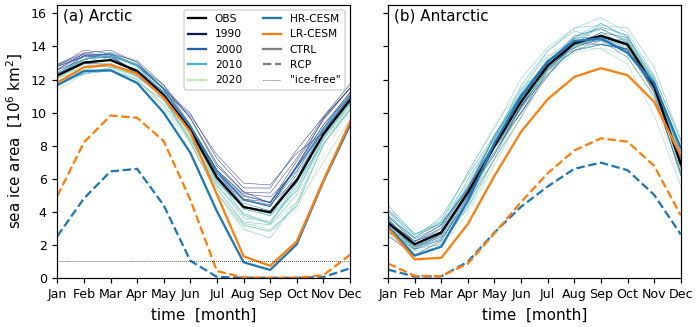

In [218]:
f, ax = plt.subplots(1,2, figsize=(6.4,3), sharey=True, sharex=True)
ax[0].set_ylabel(r'sea ice area  [10$^6$ km$^2$]')
handles = []
for i, region in enumerate(['Arctic','Antarctic']):
    ax[i].set_xlabel('time  [month]')
    ax[i].text(0.02,.94,['(a','(b'][i]+f') {region}', transform=ax[i].transAxes)
    
    all_files = glob.glob(f'{path_data}/NSIDC/'+['N','S'][i]+'*.csv')
    df = pd.concat((pd.read_csv(f) for f in all_files))
    format = '%Y-%m'
    df['date'] = pd.to_datetime(df['year'].astype(str)+'-'+df[' mo'].astype(str), format=format)
    df = df.set_index(pd.DatetimeIndex(df['date']))
    df = df.sort_index()
    df = df['   area']['1990-01-01':'2020-12-01']
    dm = df.groupby(df.index.month).mean()
    for y in df.index.year.unique():
        c = plt.get_cmap('YlGnBu_r')((y-1990)/40)
        ax[i].plot(np.arange(12), df[str(y)], c=c, ls='-', lw=.3)
        if i==0 and y%10==0:
            print(i, y)
            l, = ax[i].plot([],[], c=c, label=y)
            handles.append(l)
    lo, = ax[i].plot(np.arange(12), dm, c='k', ls='-' , label='OBS')
#     ax[0].legend(handles=handles)
    
    
    ctrl = xr.open_dataarray(f'{path_samoc}/CICE/CICE_{region}_ctrl.nc')
    rcp  = xr.open_dataarray(f'{path_samoc}/CICE/CICE_{region}_rcp.nc' )
    lpd  = xr.open_dataarray(f'{path_samoc}/CICE/CICE_{region}_lpd.nc' )
    lr1  = xr.open_dataarray(f'{path_samoc}/CICE/CICE_{region}_lr1.nc' )
    lh, = ax[i].plot(ctrl.groupby('time.month').mean('time').roll(month=-1)/1e14, c='C0', ls='-' , label='HR-CESM')
    ax[i].plot(rcp .groupby('time.month').mean('time').roll(month=-1)/1e14, c='C0', ls='--')
    ll, = ax[i].plot(lpd .groupby('time.month').mean('time').roll(month=-1)/1e14, c='C1', ls='-' , label='LR-CESM')
    ax[i].plot(lr1 .groupby('time.month').mean('time').roll(month=-1)/1e14, c='C1', ls='--')
    lc, = ax[i].plot([],[],c='grey', ls='-' , label='CTRL')
    lr, = ax[i].plot([],[],c='grey', ls='--', label='RCP')
ax[0].set_ylim((0,None))
ax[0].set_xlim((0,11))
ax[0].set_xticks(np.arange(12))
ax[0].set_xticklabels(calendar.month_abbr[i] for i in np.arange(1,13))
li = ax[0].axhline(1, c='k', ls=':', lw=.5, label='"ice-free"')
ax[0].legend(handles=[lo]+handles+[lh,ll,lc,lr,li], ncol=2, loc='upper right', fontsize=7, handlelength=1.7)
# ax[1].legend(handles=handles      , loc='center left', fontsize=8, handlelength=1.7)
plt.savefig(f'{path_results}/thesis/2_seaice.eps')